# Problem: choose the right location to open a restaurant in a turistic place in Sicily - Italy

Our Client, one of the most famous and awarded chefs in Italy, is considering starting a new business in Sicily. More specifically, his business idea is to open a new restaurant in one of the top summer locations on the Sicilian coasts.
The main requirements are:
- The restaurant should be close (<1km range) to one of the top 50 beaches in Sicily (as a driver for the most touristic places).
- The location should be determined considering the density of other restaurants in the area, excluding indirect competitors such as fast food, wine bars, pubs, beach bars, bars, café, and other not direct competitors.
The Client is asking the support of a data-driven analysis in order to make the final choice for the location.


## Importing Python libraries

In [135]:
import pandas as pd
import requests
import matplotlib.cm as cm
from matplotlib import colors
from bs4 import BeautifulSoup as bs4
import re
from sklearn.cluster import KMeans
import numpy as np
!pip install folium
import folium
from geopy.geocoders import Nominatim # uncomment this line if you haven't completed the Foursquare API lab

## Scraping data

Looking on the Internet I've found <a href="https://www.marcopolo.tv/sicilia-spiagge">this website</a> which lists the top 50 beaches in Italy (we will focus on summer location closer to the seaside).
I'm going to scrape data using bs4 and then I'll create a DataFrame.

In [2]:
wikilink = 'https://www.marcopolo.tv/sicilia-spiagge'
session = requests.Session()
response = session.get(wikilink)

In [3]:
soup = bs4(response.text , 'xml') 

In [4]:
weblist = soup.find_all("h4") 

In [536]:
beaches = []
for i in weblist:
    if 'https' in str(i): #a couple of 'h4' are img links, that I don't need
        pass
    else:
        #some transformation needed for cleaning location names and make it "readable" to geopy.
        beach = str(i).replace('<h4>','').replace('</h4>','').split(')')[1][1:].replace('Caldura', "Cefalù").replace('Cala Capreria, Trapani', "Cala Capreria, Riserva Zingaro").replace('Foce dellAlcantara','').replace('Spiagge Bianche', 'Lipari').replace('Capo San Marco', 'Sciacca').replace('SantAmbrogio','Cefalù').replace('Cala dei Turchi, Mazara del Vallo','Scala dei Turchi, Agrigento' ).replace('Caltabiano', 'Calatabiano') #cleaning
        beaches.append(beach)

In [537]:
print('And these are the top {} beaches in Sicily:'.format(len(beaches)))
for beach in beaches:
    print(beach)

And these are the top 50 beaches in Sicily:
Mondello, Palermo
Isola delle Femmine
Cala Capreria, Riserva Zingaro
La Praiola, Terrasini
Magaggiari, Cinisi
Cefalù, Cefal
Pollina  Torre Conca, Palermo
Punta Spalmatore, Ustica
Cala Junco, Panarea
Pollara, Salina
Cala Croce, Lampedusa
Tindari  Marinello, Messina
Vendicari, Noto
Baia di SantAntonio, Milazzo
Lipari, Lipari
Isola Bella, Taormina
Santa Tecla, Acireale
San Marco  , Calatabiano
Cefalù, Cefal
Foce del Simeto, Catania
Marina di Cottone, Catania
Calamosche, Siracusa
Fontane Bianche, Siracusa
San Lorenzo, Siracusa
Eloro  Pizzuta, Siracusa
Santa Maria del Focallo, Ragusa
Marina di Modica
Marina di Ragusa
Playa Grande, Ragusa
Punta Secca, Ragusa
Randello, Ragusa
Pozzallo, Ragusa
Punta Braccetto, Ragusa
Porto Palo di Menfi, Agrigento
Seccagrande, Ribera
Scala dei Turchi, Agrigento
Isola dei Conigli, Lampedusa
Cala Pozzolana, Linosa
Sciacca, Sciacca
Playa Carratois, Portopalo di Capopassero
Spiaggia Isola di Capo Passero
Cala Vincenzina,

## Retrieving geo-coordinates

Now let's use geopy to get geo-coordinates for each location in the list "beaches"

In [538]:
def geoloc(placeslist):
    geolocator = Nominatim(user_agent="rpgl")
    df=pd.DataFrame()
    for place in placeslist:
    
        try:
            location = geolocator.geocode(place)
            lat = location.latitude
            lon = location.longitude
        except:
            try:
                splitted = place.split(',')[0]
                location = geolocator.geocode(splitted)
                lat = location.latitude
                lon = location.longitude
            except:
                lat = 'NA'
                lon = 'NA'
                pass
        df = df.append({'Place':place, 'Lat':lat, 'Lon':lon}, ignore_index = True)
    return df

In [539]:
geodf = geoloc(beaches)

Let's clean the DataFrame from "NA"

In [540]:
geodf = geodf.loc[geodf['Lat']!='NA']

We also need to drop duplicate values, if any:

In [541]:

geodf = geodf.drop_duplicates(keep = 'first')

In [542]:
geodf

,Lat,Lon,Place
0,38.2062,13.3246,"Mondello, Palermo"
1,38.1983,13.2473,Isola delle Femmine
2,38.0878,12.8048,"Cala Capreria, Riserva Zingaro"
3,38.1547,13.0808,"La Praiola, Terrasini"
4,38.1622,13.0876,"Magaggiari, Cinisi"
5,38.035,14.0245,"Cefalù, Cefal"
6,38.0234,14.143,"Pollina Torre Conca, Palermo"
7,38.7002,13.1514,"Punta Spalmatore, Ustica"
8,38.6253,15.0626,"Cala Junco, Panarea"
9,38.5798,14.8278,"Pollara, Salina"


 ## Data visualization

Let's visualize data on the Map using Folium

First of all, let's calculate the center of the map as the mean value of lat and lon values in the list:

In [543]:
center = [geodf['Lat'].mean(), geodf['Lon'].mean()]
print('Center of the map (Lat = {}, Lon = {})'.format(round(center[0],2), round(center[1],2)))

Center of the map (Lat = 37.41, Lon = 14.1)


In [544]:
m = folium.Map(location= center, zoom_start= 8)
# add markers to map
for lat, lng, spiaggia in zip(geodf['Lat'], geodf['Lon'], geodf['Place']):
    label = '{}'.format(spiaggia)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(m)  


In [545]:
m

## Retrieving information about venues using Foursquare API

Below I set up the Foursquare API and define parameters:

In [546]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's retrieve the relevant information about venues for each location:

In [613]:
def get_near_by_venues(names, latitudes, longitudes, radius=1000, limit = 100): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Beach', 'Venue_Name', 'Lat', 'Lon', 'Category']
    
    return nearby_venues

In [614]:
sicilian_places = get_near_by_venues(names=geodf['Place'],latitudes=geodf['Lat'],
                                   longitudes=geodf['Lon'])

In [615]:
sicilian_places.columns = ['Place', 'Lat', 'Lon', 'Venue_Name', 'Category']

In [616]:
sicilian_places

,Place,Lat,Lon,Venue_Name,Category
0,"Mondello, Palermo",38.206214,13.324552,Piazza Mondello,Plaza
1,"Mondello, Palermo",38.206214,13.324552,Trattoria Da Piero,Trattoria/Osteria
2,"Mondello, Palermo",38.206214,13.324552,Bar Touring,Bar
3,"Mondello, Palermo",38.206214,13.324552,Da Sariddu,Seafood Restaurant
4,"Mondello, Palermo",38.206214,13.324552,Billy's,Burger Joint
...,...,...,...,...,...
446,"Castellammare del Golfo, Trapani",38.018846,12.885837,Ristobar Agorà,Sandwich Place
447,"Castellammare del Golfo, Trapani",38.018846,12.885837,Bistrot Risto-Pub,Bistro
448,"Castellammare del Golfo, Trapani",38.018846,12.885837,Hotel Punta Nord Est,Hotel
449,"Castellammare del Golfo, Trapani",38.018846,12.885837,Villa Comunale Regina Margherita,Park


Let's esclude venue category = 'Beach' as they are out of scope of our analysis

In [617]:
sicilian_places = sicilian_places.loc[sicilian_places['Category'] != 'Beach']#.loc[sicilian_places['Category'] != 'Nature Preserve'].loc[sicilian_places['Category'] != 'Lighthouse']

In [618]:
piv = pd.pivot_table(sicilian_places, index = 'Category', values = 'Venue_Name', aggfunc = 'count').reset_index()
piv = piv.rename(columns = {'Venue_Name':'Count'})
piv = piv.sort_values(by = 'Count', ascending = False)#.set_index('Category')
top10 = piv[:10]
top10

,Category,Count
41,Hotel,47
45,Italian Restaurant,46
14,Café,32
56,Pizza Place,24
62,Restaurant,23
67,Seafood Restaurant,18
57,Plaza,12
44,Ice Cream Shop,12
18,Cocktail Bar,9
73,Trattoria/Osteria,8


In [619]:
other = 4
piv['Type'] =  np.where(piv['Category'].str.contains('Restaurant'), 'Restaurant', 
                        np.where(piv['Category'].str.contains('Bar'), 'Bar', 
                                 np.where(piv['Category'].str.contains('Pub'), 'Pub',                         
                                 np.where(piv['Count']<=other, 'Other', piv['Category']) )))
summ = piv.groupby(by = 'Type').sum()

summ

,Count
Type,
Bar,22
Café,32
Campground,6
Harbor / Marina,7
Historic Site,5
Hotel,47
Ice Cream Shop,12
Other,80
Pizza Place,24


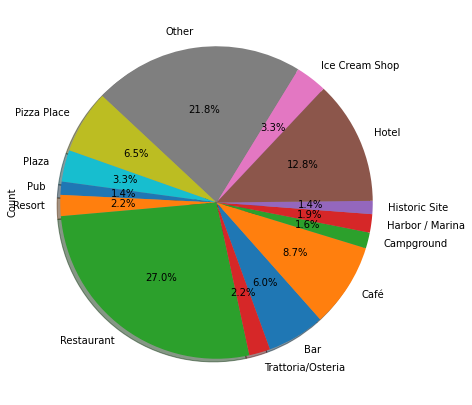

In [620]:
summ.plot(y = 'Count', kind = 'pie', figsize = (7, 30), fontsize = 10, legend = False, autopct='%1.1f%%', startangle=290, shadow = True)

In [621]:
piv.loc[piv['Type']=='Other'].groupby(by = 'Category').sum().sort_values(by = 'Count',ascending = False)

,Count
Category,
Lighthouse,4
Dessert Shop,4
Train Station,3
Supermarket,3
Park,3
Burger Joint,3
Scenic Lookout,3
Sandwich Place,3
Diner,3


In [622]:
print('A total number of {} venues have been retrieved. The first {} most popular venue categories account for about {} % of the total.'.format(piv['Count'].sum(), top10['Count'].count(), int(top10['Count'].sum()/piv['Count'].sum()*100)))

A total number of 367 venues have been retrieved. The first 10 most popular venue categories account for about 62 % of the total.


***As expected, a significant number of venues are restaurants. Now we need to understand in which locations there is less "density" of restaurants compared to other venues. A good strategy could be opening a restaurant where there are less competitors.***

## One hot encoding

In [623]:
sicilian_places['Type'] =  np.where(sicilian_places['Category'].str.contains('Restaurant'), 'Restaurant', np.where(sicilian_places['Category'].str.contains('Bar'), 'Bar', np.where(sicilian_places['Category'].str.contains('Pub'), 'Pub', sicilian_places['Category'])))

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [624]:
dt = pd.get_dummies(sicilian_places[['Type']], prefix= "", prefix_sep= " ")

dt['Place'] = sicilian_places['Place'] # add neighborhood column back to dataframe

fixed_columns = [dt.columns[-1]] + list(dt.columns[:-1]) # moving neighborhood column to the first column
dt = dt[fixed_columns]
print(dt.shape)
dt.head()

(367, 65)


,Place,Art Museum,Bakery,Bar,Bathing Area,Bay,Bed & Breakfast,Bistro,Boat or Ferry,Breakfast Spot,...,Restaurant,River,Sandwich Place,Scenic Lookout,Sculpture Garden,Snack Place,Supermarket,Surf Spot,Train Station,Trattoria/Osteria
0,"Mondello, Palermo",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Mondello, Palermo",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"Mondello, Palermo",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Mondello, Palermo",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"Mondello, Palermo",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [625]:
dtg = dt.groupby('Place').mean().reset_index()
print(dtg.shape)
dtg.head()

(39, 65)


,Place,Art Museum,Bakery,Bar,Bathing Area,Bay,Bed & Breakfast,Bistro,Boat or Ferry,Breakfast Spot,...,Restaurant,River,Sandwich Place,Scenic Lookout,Sculpture Garden,Snack Place,Supermarket,Surf Spot,Train Station,Trattoria/Osteria
0,"Baia di SantAntonio, Milazzo",0.0,0.0,0.250000,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.000000
1,"Cala Capreria, Riserva Zingaro",0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
2,"Cala Croce, Lampedusa",0.0,0.0,0.166667,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.166667,0.0,0.0,0.0,0.166667
3,"Cala Junco, Panarea",0.0,0.0,0.000000,0.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000
4,"Cala Levante, Pantelleria",0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000


## Analyzing the top venues for each location

In [626]:
num_top_venues = 5

for place in dtg['Place']:
    print("----"+place+"----")
    temp = dtg[dtg['Place'] == place].T.reset_index()
    temp.columns = ['venue','freq']
    
    #first rows is not usefull
    temp = temp.iloc[1:]
    temp['freq'] = round(temp['freq'].astype(float),2)# converting into float type and # taking round values
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True) # sorting the dataframe by 'freq' in decreasing order
    print(temp.head(num_top_venues))
    print('\n')

----Baia di SantAntonio, Milazzo----
             venue  freq
0   Scenic Lookout  0.25
1              Bar  0.25
2     Bathing Area  0.25
3            Hotel  0.25
4           Lounge  0.00


----Cala Capreria, Riserva Zingaro----
             venue  freq
0   History Museum   0.5
1           Museum   0.5
2       Art Museum   0.0
3           Bakery   0.0
4    Historic Site   0.0


----Cala Croce, Lampedusa----
                venue  freq
0   Trattoria/Osteria  0.17
1         Snack Place  0.17
2                Food  0.17
3                Café  0.17
4     Harbor / Marina  0.17


----Cala Junco, Panarea----
             venue  freq
0              Bay   1.0
1       Art Museum   0.0
2      Pizza Place   0.0
3   History Museum   0.0
4           Hostel   0.0


----Cala Levante, Pantelleria----
         venue  freq
0       Resort   0.5
1   Restaurant   0.5
2   Art Museum   0.0
3       Lounge   0.0
4         Park   0.0


----Cala Pozzolana, Linosa----
            venue  freq
0             Bar  0.25

In [627]:
def return_most_common_venues(row, num_top_venues):
    row = row.iloc[1:]
    row_sorted = row.sort_values(ascending=False)
    return row_sorted.index.values[0:num_top_venues]

In [628]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Place']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most popular venue type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most popular venue type'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Place'] = dtg['Place']

for ind in np.arange(dtg.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(dtg.iloc[ind, :], num_top_venues)


In [629]:
venues_sorted

,Place,1st most popular venue type,2nd most popular venue type,3rd most popular venue type,4th most popular venue type,5th most popular venue type,6th most popular venue type,7th most popular venue type,8th most popular venue type,9th most popular venue type,10th most popular venue type
0,"Baia di SantAntonio, Milazzo",Bar,Bathing Area,Scenic Lookout,Hotel,Trattoria/Osteria,Food & Drink Shop,Cruise Ship,Cupcake Shop,Dessert Shop,Diner
1,"Cala Capreria, Riserva Zingaro",History Museum,Museum,Trattoria/Osteria,Coffee Shop,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Stand,Food Court,Food & Drink Shop
2,"Cala Croce, Lampedusa",Trattoria/Osteria,Food,Bar,Snack Place,Harbor / Marina,Café,Cruise Ship,Cupcake Shop,Dessert Shop,Diner
3,"Cala Junco, Panarea",Bay,Trattoria/Osteria,Coffee Shop,Gastropub,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Stand,Food Court,Food & Drink Shop
4,"Cala Levante, Pantelleria",Restaurant,Resort,Trattoria/Osteria,Creperie,Cruise Ship,Cupcake Shop,Dessert Shop,Diner,Food,City
5,"Cala Pozzolana, Linosa",Restaurant,Bar,Café,Boat or Ferry,Food & Drink Shop,Cruise Ship,Cupcake Shop,Dessert Shop,Diner,Food
6,"Cala Rossa, Favignana",Grocery Store,Harbor / Marina,Sculpture Garden,Food Truck,Food Stand,Trattoria/Osteria,Diner,Creperie,Cruise Ship,Cupcake Shop
7,"Castellammare del Golfo, Trapani",Hotel,Ice Cream Shop,Café,Restaurant,Pizza Place,Gastropub,Bar,Park,Sandwich Place,Bistro
8,"Cefalù, Cefal",Restaurant,Pizza Place,Bar,Café,Hotel,Historic Site,Ice Cream Shop,Plaza,Harbor / Marina,Gourmet Shop
9,"Fontane Bianche, Siracusa",Restaurant,Hotel,Train Station,Bathing Area,Resort,Cruise Ship,Cupcake Shop,Dessert Shop,Diner,Food


## Clustering

I'm considering number of clusters = 3

In [639]:
k = 3

X = dtg.drop('Place', axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters = k, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=0)

In [640]:
# add clustering labels
venues_sorted['Cluster_Labels']=  kmeans.labels_

merged = geodf

merged = pd.merge(merged, venues_sorted, on = 'Place', how = 'left') #merged.join(venues_sorted.set_index('Place'), on='Place')

merged.head()

,Lat,Lon,Place,1st most popular venue type,2nd most popular venue type,3rd most popular venue type,4th most popular venue type,5th most popular venue type,6th most popular venue type,7th most popular venue type,8th most popular venue type,9th most popular venue type,10th most popular venue type,Cluster_Labels
0,38.2062,13.3246,"Mondello, Palermo",Restaurant,Hotel,Burger Joint,Trattoria/Osteria,Harbor / Marina,Ice Cream Shop,Café,Plaza,Fried Chicken Joint,Bar,0.0
1,38.1983,13.2473,Isola delle Femmine,Restaurant,Café,Supermarket,Train Station,Fried Chicken Joint,Food Truck,Food Stand,Food Court,Food & Drink Shop,City,0.0
2,38.0878,12.8048,"Cala Capreria, Riserva Zingaro",History Museum,Museum,Trattoria/Osteria,Coffee Shop,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Stand,Food Court,Food & Drink Shop,0.0
3,38.1547,13.0808,"La Praiola, Terrasini",Restaurant,Café,Hotel,Bar,Plaza,Port,Cruise Ship,Cupcake Shop,Dessert Shop,Diner,0.0
4,38.1622,13.0876,"Magaggiari, Cinisi",Restaurant,Hotel,Café,Port,Trattoria/Osteria,Food Court,Food & Drink Shop,Food Stand,Food,City,0.0


In [641]:
merged.dtypes
merged['Cluster_Labels'].unique()

array([ 0.,  1.,  2., nan])

Check NA:

In [642]:
merged['Cluster_Labels'] = np.where(merged['Cluster_Labels'].isnull(),0,merged['Cluster_Labels'])

In [643]:
merged = merged.dropna()

## Visualization of Results

In [644]:
# create map
map_clusterd = folium.Map(location=center, zoom_start=8)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.gnuplot(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Lat'], merged['Lon'],
                                  merged['Place'], merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.3).add_to(map_clusterd)
       
map_clusterd

**RESULTS**: The analysis shows an opportunity for a new restaurant in "Vendicari, Noto" and "Cala Capreria, Trapani", as no traditional Restaurants are present (there are some Fast foods and wine bars which are not our direct competitors).

In [649]:
merged.loc[merged['Cluster_Labels'] == 2.00]

,Lat,Lon,Place,1st most popular venue type,2nd most popular venue type,3rd most popular venue type,4th most popular venue type,5th most popular venue type,6th most popular venue type,7th most popular venue type,8th most popular venue type,9th most popular venue type,10th most popular venue type,Cluster_Labels
8,38.6253,15.0626,"Cala Junco, Panarea",Bay,Trattoria/Osteria,Coffee Shop,Gastropub,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Stand,Food Court,Food & Drink Shop,2.0


In [646]:
merged1 = merged[['Place', 'Cluster_Labels']]

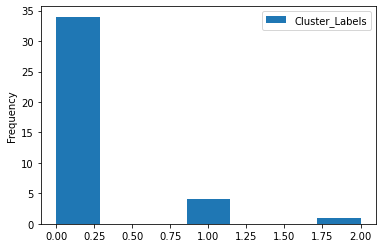

In [655]:
merged1.plot.hist(bins = 7)

In [ ]:
summ.plot(y = 'Count', kind = 'pie', figsize = (7, 30), fontsize = 10, legend = False, autopct='%1.1f%%', startangle=290, shadow = True)